<a href="https://colab.research.google.com/github/michelleaeh/ADissertation/blob/master/34MScCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Project:** MSc in Robotics and Intelligent Systems Dissertation

**Author:** Michelle Alejandra Espinosa Hernandez

**Student registration number:** 1900964

**Student PRID:** ESPIN62803

**Date:** September 2020 

**Purpose:** Obtain classification accuracy among different types of sensors and different data processing steps

# **Data description**

**Myo armband dataset from https://data.mendeley.com/datasets/wgswcr8z24/2**


The dataset consits of .csv files collected from two Myo armbands. The format of the files are [word_name]_[id]. The ‘word_name’ is the English translation of the American Sign Language word used and the ‘id’ is a unique identifier. The .zip for each of the above links has sub-folders for each User.

Each file has 50 columns. They represent a sub-sampled data collection from two Myo devices worn on left and right hands of the signer. The first column is the ‘Counter’ that goes from 1 to 50.

The following columns are of the format: [Sensor][pod/direction][left/right]. For instance the EMG reading for the first EMG pod (out of 8) on the left hand would be called EMG0R and the accelerometer reading for the Z axis on the left hand would be called: AXL

If you use this dataset please cite the following papers:

@inproceedings{paudyal2016sceptre,
title={Sceptre: a pervasive, non-invasive, and programmable gesture recognition technology},
author={Paudyal, Prajwal and Banerjee, Ayan and Gupta, Sandeep KS},
booktitle={Proceedings of the 21st International Conference on Intelligent User Interfaces},
pages={282--293},
year={2016},
organization={ACM}
}

@inproceedings{paudyal2017dyfav,
title={Dyfav: Dynamic feature selection and voting for real-time recognition of fingerspelled alphabet using wearables},
author={Paudyal, Prajwal and Lee, Junghyo and Banerjee, Ayan and Gupta, Sandeep KS},
booktitle={Proceedings of the 22nd International Conference on Intelligent User Interfaces},
pages={457--467},
year={2017},
organization={ACM}
}

**Frequency:**

50Hz sampling rate

**Words:**

*36 total words*

allmorning, bird, blue, cantsleep, cat, colrunnynose, continuouslyforanhour, cost, day, dollar, everymorning, everynight, gold, goodnight, happy, headache, home, horse, hot, hurt, itching, large, mom, monthly, notfeelgood, orange, pizza, please, shirt, soreness, swelling, takeliquidmedicine, thatsterrible, tired, upsetstomach, wash


**Filenames:**

*849 total files*

(word)_(user#)(try#)


**Columns of files:**

Counter  (1 -> 50)

EMG0L -> EMG7L  (EMG sensor readings)

AXL, AYL, AZL  (accelerometer readings)

GXL, GYL, GZL  (gyroscope readings)

ORL, OPL, OYL  (magnetometer readings?)

EMG0R -> EMG7R  (EMG sensor readings)

AXR, AYR, AZR  (accelerometer readings)

GXR, GYR, GZR  (gyroscope readings)

ORR, OPR, OYR  (magnetometer readings?)

features=['EMG0L', 'EMG1L', 'EMG2L', 'EMG3L', 'EMG4L', 'EMG5L', 'EMG6L', 'EMG7L', 'AXL', 'AYL', 'AZL', 'GXL', 'GYL', 'GZL', 'ORL', 'OPL', 'OYL', 'EMG0R', 'EMG1R', 'EMG2R', 'EMG3R', 'EMG4R', 'EMG5R', 'EMG6R', 'EMG7R', 'AXR', 'AYR', 'AZR', 'GXR', 'GYR', 'GZR', 'ORR', 'OPR', 'OYR']


**Size of files:**

All files are 50 rows x 35 columns except continuouslyforanhour_22.csv, headache_52.csv, home_61.csv, and mom_82.csv which are 101 rows x 35 columns

**Steps:**

1. Combine files
2. Normalize or standardize matrix
3. Apply Butterworth
4. Apply PCA
5. Input to SVM


# **Variable definition**

In [1]:
numreps=34      # Number of epochs per word
num_trials=10  # Number of runs of cross validation


# **1. Preparation of data**

**1.1. Start up and initialization of variables**

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os.path
import pandas as pd
import random
import scipy as sp
import time
import warnings

from collections import Counter
from google.colab import files
from mpl_toolkits import mplot3d
from scipy import signal
from scipy.io import loadmat
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from zipfile import ZipFile

# Start timer
starttime = time.time()

# Eliminate warnings
warnings.filterwarnings("ignore")

# Extract all files from zip
with ZipFile("/content/2MyoASL.zip", 'r') as zip:
  zip.extractall()

# Division of sensors
emg=['EMG0L', 'EMG1L', 'EMG2L', 'EMG3L', 'EMG4L', 'EMG5L', 'EMG6L', 'EMG7L', 
     'EMG0R', 'EMG1R', 'EMG2R', 'EMG3R', 'EMG4R', 'EMG5R', 'EMG6R', 'EMG7R']
acc=['AXL', 'AYL', 'AZL', 'AXR', 'AYR', 'AZR']
gyro=['GXL', 'GYL', 'GZL', 'GXR', 'GYR', 'GZR']
ori=['ORL', 'OPL', 'OYL', 'ORR', 'OPR', 'OYR']
colnames=emg[:8]+acc[:3]+gyro[:3]+ori[:3]+emg[8:]+acc[3:]+gyro[3:]+ori[3:]

# Words
words=['allmorning', 'bird', 'blue', 'cantsleep', 'cat', 'coldrunnynose', 'continuouslyforanhour', 'cost', 'day', 
       'dollar', 'everymorning', 'everynight', 'gold', 'goodnight', 'happy', 'headache', 'home', 'horse', 'hot', 
       'hurt', 'itching', 'large', 'mom', 'monthly', 'notfeelgood', 'orange', 'pizza', 'please', 'shirt', 
       'soreness', 'swelling', 'takeliquidmedicine', 'thatsterrible', 'tired', 'upsetstomach', 'wash']

# Generation of matrices
### Combinations of sensors (E=emg=3, A=acc=5, G=gyro=7, O=ori=11)
comb=['E', 'A', 'G', 'O', 'EA', 'EG', 'EO', 'AG', 'AO', 'GO', 'EAG', 'EAO', 'EGO', 'AGO', 'EAGO'] 
products=[3, 5, 7, 11, 15, 21, 33, 35, 55, 77, 105, 165, 231, 385, 1155] 
### Combinations of steps (N=Normalization=3, S=Standardization=5, B=Butterworth=7, P=PCA=11, V=SVM=13)
nsteps=['V', 'NV', 'SV', 'BV', 'PV', 'NBV', 'NPV', 'SBV', 'SPV', 'BPV', 'NBPV', 'SBPV'] 
steps=[13, 39, 65, 91, 143, 273, 429, 455, 715, 1001, 3003, 5005] 
### Placeholders
fresults=np.zeros((len(steps),len(products)))
params=np.zeros((len(steps),len(products)))
headers=np.empty(1701, dtype=object)
lengths=np.zeros(849, dtype=int)
repsum=np.zeros(37,dtype=int)
reps=np.zeros(36,dtype=int)
features=np.zeros(15)
target=np.zeros(15)
fn=np.arange(1701)
matrix=np.zeros(1)
stanproducts=[]
normproducts=[]
regproducts=[]
cmatrix=[]

# Initiation of counters
wordnum=-1
counter=-1
rownum=-1
start=0
num=0
n=0

**1.2. Combine all files**

In [3]:
for w in words:
  repcount=0
  wordnum+=1
  for i in range (10, 120):
    path='/content/2MyoASL/' + w + '_' + str(i) + '.csv'
    if os.path.exists(path)==True:
      counter+=1
      repcount+=1
      trial=pd.read_csv(path)
      trial.reset_index(drop=True)
      
      # Assign word number to each row and make data horizontal
      row=np.zeros(1)
      for t in range(35):
        if t==0:
          row[0]=wordnum
        else:
          sensor=trial.iloc[0:50,t].values
          sensor.reshape([1,50])
          row=np.concatenate((row, sensor))
      prev=row
      
      # Combine all trials
      if counter==0:
        matrix=prev
      else:
        matrix=np.concatenate([matrix,prev])

  reps[wordnum]=repcount
  if wordnum>0:
    repsum[wordnum]=reps[wordnum-1]+repsum[wordnum-1]
    repsum[36]=849

# Create header name array
headers[0]='Word'
for c in colnames:
  for t in range(50):
    num+=1
    headers[num]=c

# Give format to final matrix 
matrix=matrix.reshape([849,1701])
matrix=pd.DataFrame(matrix, columns=headers)
matrix=pd.concat([matrix['Word'],matrix[emg],matrix[acc],matrix[gyro],matrix[ori]],axis=1)
exec("matrix.to_csv(path_or_buf='/content/complete_matrix_'+str(numreps)+'.csv')")
print('Reps of each word:',reps)
print('Cummulative reps:',repsum)

Reps of each word: [19 24 32 20 24 20 19 31 24 29 20 21 23 33 34 18 27 24 35 19 17 34 30 19
 22 21 23 27 27  4 20 19 20 20 21 29]
Cummulative reps: [  0  19  43  75  95 119 139 158 189 213 242 262 283 306 339 373 391 418
 442 477 496 513 547 577 596 618 639 662 689 716 720 740 759 779 799 820
 849]


**1.3. Calculate mean and standard deviation of each sensor and each file**

In [4]:
# Average and standard deviation of each sensor in each file
for s in colnames:
  avg=matrix[s].mean(axis=1)
  sd=matrix[s].std(axis=1)
  sensor=pd.concat([avg.rename(s+': Mean_'),sd.rename('St. dev.')], axis=1)
  if s=='EMG0L':
    asd=sensor
  else:
    asd=pd.concat([asd, sensor], axis=1)
print('Average and standard deviation of each sensor per file')
print(asd)

# Average and standard deviation of each file
avg=matrix.mean(axis=1)
sd=matrix.std(axis=1)
print('Average and standard deviation of each file')
pd.concat([avg.rename('Mean'),sd.rename('St. dev.')], axis=1)

Average and standard deviation of each sensor per file
     EMG0L: Mean_   St. dev.  EMG1L: Mean_  ...   St. dev.  OYR: Mean_   St. dev.
0           -2.32   8.664825         -0.80  ...  28.427609       86.70  10.529356
1           -1.80   9.544739         -4.08  ...  27.821010       85.68   6.579002
2           -3.16  13.085839         -2.32  ...  30.345736       91.88  17.358924
3           -0.82  10.123099         -3.16  ...  29.645002       88.46  12.969682
4           -0.50   6.516071          2.76  ...  13.237239      116.58  18.099600
..            ...        ...           ...  ...        ...         ...        ...
844          0.56   7.754288          0.22  ...  17.236281      104.76   7.528341
845         -1.74   6.520955         -1.20  ...  21.772891       69.66  85.251036
846          1.02   7.731436          0.46  ...  22.707735       56.76  79.408415
847          0.06   5.582078          2.36  ...  23.650422       71.62  84.238701
848         -2.22   7.434860         -1.62 

,Mean,St. dev.
0,15.256437,46.545832
1,14.220110,47.316822
2,15.441784,45.614456
3,13.651092,47.038916
4,15.063294,49.105612
...,...,...
844,13.167964,41.642351
845,13.815314,42.880121
846,12.970618,42.725653
847,13.852317,43.758631


# **2. Data adjustement**

**2.1. Establish equal number of epochs per word**

In [5]:
for i in range(len(reps)-1,-1,-1):
  if reps[i]<numreps:
    for r in range(len(matrix)-1,-1,-1):
      if int(matrix.iloc[r]['Word'])==i:
        matrix=matrix.drop(r)
  elif reps[i]>numreps:
    elim=random.sample(range(repsum[i],repsum[i+1]),reps[i]-numreps)
    matrix=matrix.drop(elim)

exec("matrix.to_csv(path_or_buf='/content/equal_matrix_'+str(numreps)+'.csv')")

**2.2. Create sensor combinatory matrices: unaltered, normalized, and standardized**

In [6]:
# Eliminate unnecessary columns to create combinatory matrices
for v in products:
  fnword=[]
  fsword=[]
  m=matrix.copy()
  if v%3!=0:
    m=m.drop(emg,1)
  if v%5!=0:
    m=m.drop(acc,1)
  if v%7!=0:
    m=m.drop(gyro,1)
  if v%11!=0:
    m=m.drop(ori,1)
  
  # Separate features from target values
  x = m.iloc[:, m.columns!='Word']   # Features

  # Create column of words instead of numbers
  wordcol=np.empty(len(m), dtype=object)
  z=0
  wcol=[int(i) for i in m['Word'].values]
  for f in wcol:
    wordcol[z]=words[f]
    z+=1
  wordcol=np.asmatrix(wordcol)
  regular=np.concatenate((np.transpose(wordcol),np.copy(m.iloc[:,1:])),axis=1)
  inputmatrix=pd.DataFrame(regular,columns=m.columns).dropna(axis=1)
  regproducts.append(inputmatrix)

  for pr in range(len(inputmatrix)):
    nemg=[]
    nacc=[]
    ngyro=[]
    nori=[]
    norm=[]
    semg=[]
    sacc=[]
    sgyro=[]
    sori=[]
    stan=[]
    if emg[0] in inputmatrix:
      in_emg=inputmatrix.iloc[pr][emg]
      nemg=(in_emg-in_emg.min())/(in_emg.max()-in_emg.min())
      is_emg=inputmatrix.iloc[pr][emg].values
      is_emg=is_emg[np.newaxis]
      semg=StandardScaler().fit_transform(np.transpose(is_emg))
      semg=semg.reshape(-1)
    if acc[0] in inputmatrix:
      in_acc=inputmatrix.iloc[pr][acc]
      nacc=(in_acc-in_acc.min())/(in_acc.max()-in_acc.min())
      is_acc=inputmatrix.iloc[pr][acc].values
      is_acc=is_acc[np.newaxis]
      sacc=StandardScaler().fit_transform(np.transpose(is_acc))
      sacc=sacc.reshape(-1)
    if gyro[0] in inputmatrix:
      in_gyro=inputmatrix.iloc[pr][gyro]
      ngyro=(in_gyro-in_gyro.min())/(in_gyro.max()-in_gyro.min())
      is_gyro=inputmatrix.iloc[pr][gyro].values
      is_gyro=is_gyro[np.newaxis]
      sgyro=StandardScaler().fit_transform(np.transpose(is_gyro))
      sgyro=sgyro.reshape(-1)
    if ori[0] in inputmatrix:
      in_ori=inputmatrix.iloc[pr][ori]
      nori=(in_ori-in_ori.min())/(in_ori.max()-in_ori.min())
      is_ori=inputmatrix.iloc[pr][ori].values
      is_ori=is_ori[np.newaxis]
      sori=StandardScaler().fit_transform(np.transpose(is_ori))
      sori=sori.reshape(-1)
    
    ## Normalize each type of sensor per sample between 0 and 1
    norm=np.concatenate((np.transpose(nemg),np.transpose(nacc),np.transpose(ngyro),np.transpose(nori)))
    norm=norm[np.newaxis]
    fnword=np.append(fnword,norm)
    fnword=fnword[np.newaxis]
    
    ## Standardize each type of sensor with mean=0 and deviation=1
    stan=np.concatenate((np.transpose(semg),np.transpose(sacc),np.transpose(sgyro),np.transpose(sori)))
    stan=stan[np.newaxis]
    fsword=np.append(fsword,stan)
    fsword=fsword[np.newaxis]

  nmx=np.reshape(fnword,(len(inputmatrix),len(inputmatrix.columns)-1))
  norm_matrix=np.concatenate((np.transpose(wordcol),nmx),axis=1) 
  norm_matrix=pd.DataFrame(norm_matrix,columns=inputmatrix.columns).dropna(axis=1)
  normproducts.append(norm_matrix)
  exec("norm_matrix.to_csv(path_or_buf='/content/norm_matrix_'+str(numreps)+'.'+str(v)+'.csv')")

  smx=np.reshape(fsword,(len(inputmatrix),len(inputmatrix.columns)-1))
  stan_matrix=np.concatenate((np.transpose(wordcol),smx),axis=1) 
  stan_matrix=pd.DataFrame(stan_matrix,columns=inputmatrix.columns).dropna(axis=1)
  stanproducts.append(stan_matrix)
  exec("stan_matrix.to_csv(path_or_buf='/content/stan_matrix_'+str(numreps)+'.'+str(v)+'.csv')")


# **3. Definition of functions for steps**

**3.1. Split data into train and test sets**

In [7]:
def datasplit(inmatrix_p):
    x = inmatrix_p.iloc[:, inmatrix_p.columns!='Word']   # Features
    y = inmatrix_p.loc[:,'Word']                         # Target
    x_train_p, x_test_p, y_train_p, y_test_p = train_test_split(x, y, test_size=0.3)
    return x_train_p, x_test_p, y_train_p, y_test_p

**3.2. Butterworth**

In [8]:
def butterworth(inmatrix_b):
  fs_nyq=50/2
  b, a = sp.signal.butter(8, 20/fs_nyq, btype='highpass', fs=fs_nyq)
  if emg[0] in inmatrix_b:
    for r in range(len(inmatrix_b)):
      in_emg=inmatrix_b.iloc[r][emg].values
      emg_filtered = sp.signal.lfilter(b, a, in_emg)
      emg_filtered=emg_filtered[np.newaxis]
      inmatrix_b.iloc[r,1:len(np.transpose(emg_filtered))+1]=emg_filtered
  return inmatrix_b

**3.3. PCA**

In [9]:
def pca(x_train_c, x_test_c, y_train_c, y_test_c):
  #pca = PCA(n_components=min(len(x_train_c), len(y_train_c)))
  pca = PCA()
  pca.fit(x_train_c)
  x_t_train_pca = pca.transform(x_train_c)
  x_t_test_pca = pca.transform(x_test_c)
  return x_train_c, x_test_c, y_train_c, y_test_c, x_t_train_pca, x_t_test_pca

In [10]:
a=[[1,2,3],[4,5,6]]
print(len(a[0]))

3


**3.4. SVM with Grid Search**

In [11]:
def svm(x_train_s, x_test_s, y_train_s, y_test_s, x_t_train_s, x_t_test_s,combo):
    #parameters = {'kernel':('linear', 'poly', 'rbf', 'sigmoid'), 'C':[0.1, 1, 10, 100, 1000]}
    svc = SVC(max_iter=1000)
    nested_scores=np.zeros(num_trials)
    for t in range(num_trials):
      inner_cv=KFold(n_splits=10,shuffle=True,random_state=i)
      outer_cv=KFold(n_splits=10,shuffle=True,random_state=i)
      #clf=GridSearchCV(svc,parameters,scoring='accuracy',n_jobs=1,cv=outer_cv)
      clf=svc
      clf.fit(x_t_train_s, y_train_s)
      nested_scores=cross_val_score(clf,x_t_test_s,y_test_s,cv=outer_cv)
      nested_scores[i]=nested_scores.mean()
    y_pred=clf.predict(x_t_test_s)
    
    # Confusion matrix
    plot_confusion_matrix(clf, x_t_test_s, y_test_s, cmap=plt.cm.Blues)
    plt.title(combo)
    plt.show()

    #bestpar=clf.best_params_
    accuracy=nested_scores.mean()
    svmresult=classification_report(y_test_s, y_pred)
    #return svmresult,accuracy, bestpar
    return svmresult,accuracy

# **4. Main code**

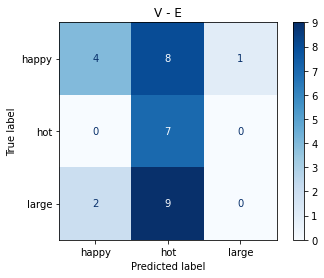

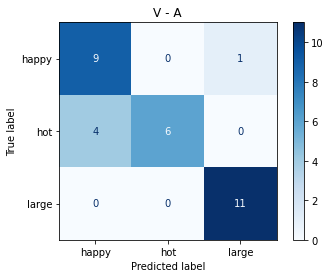

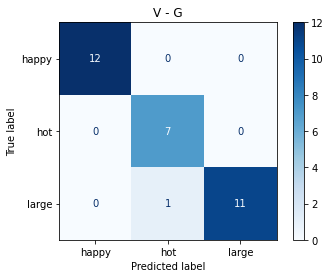

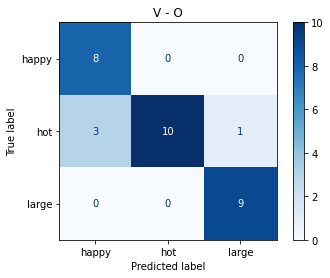

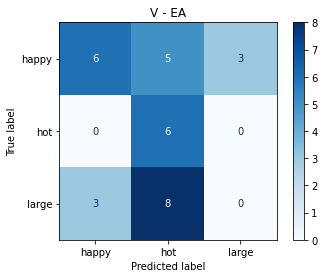

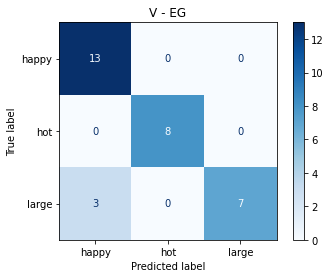

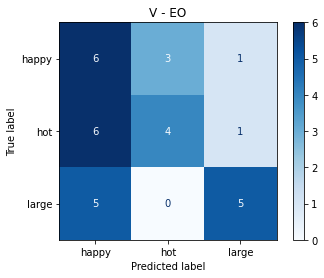

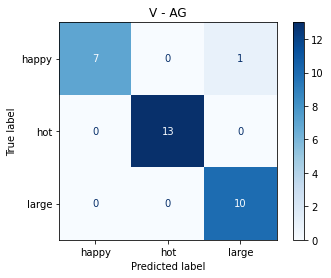

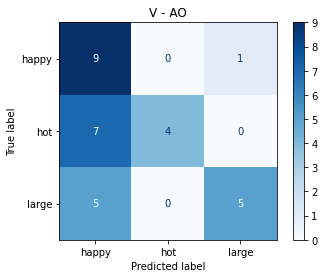

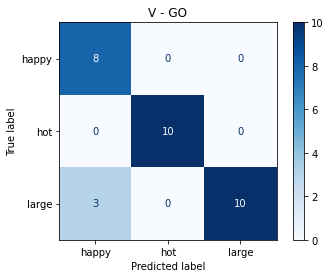

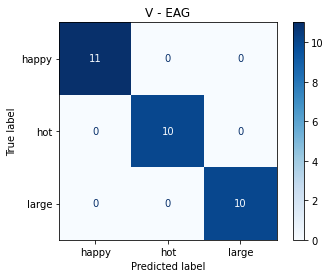

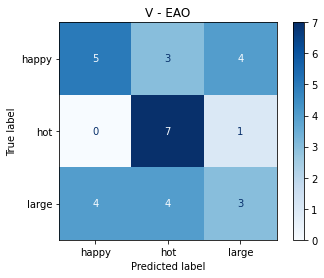

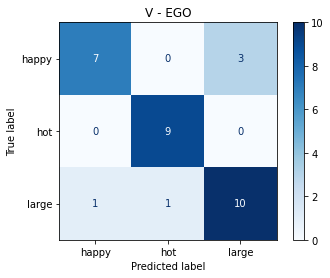

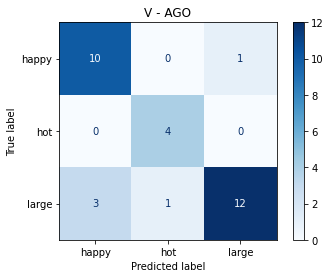

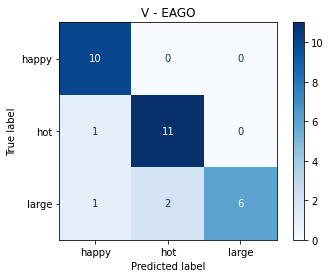

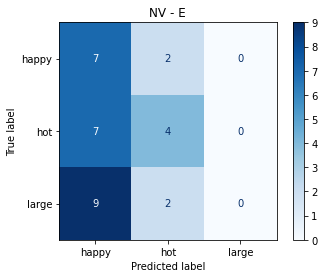

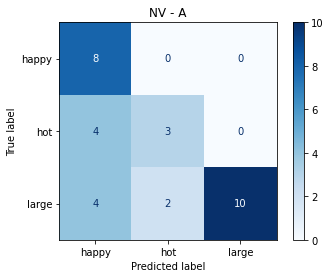

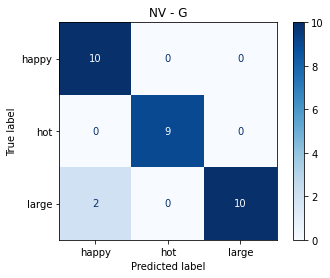

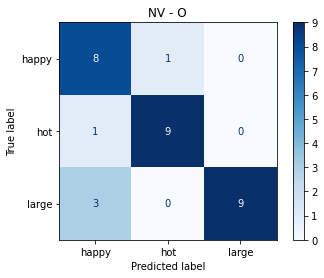

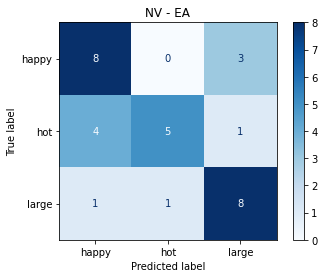

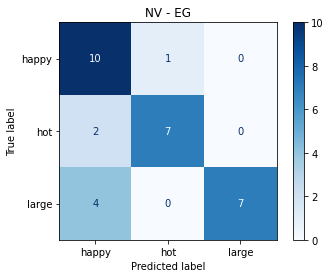

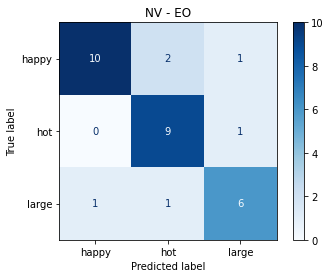

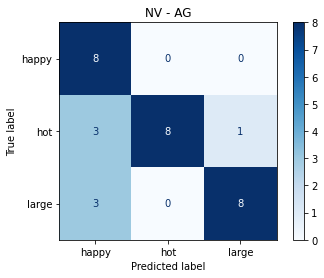

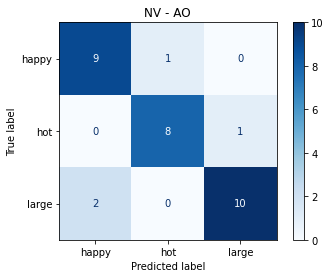

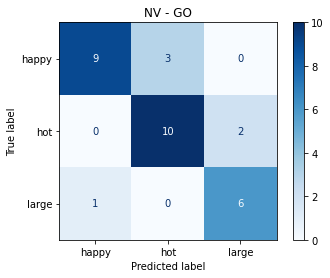

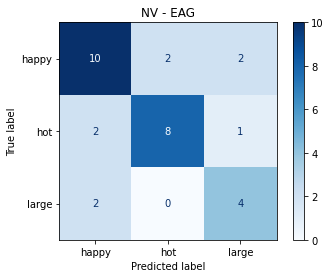

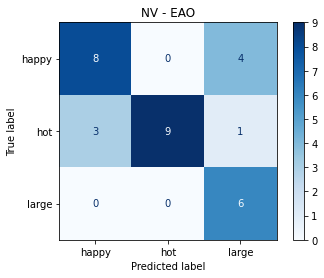

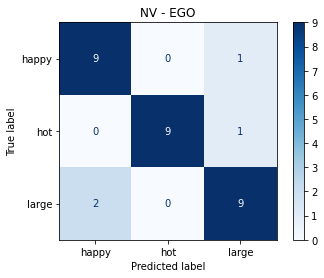

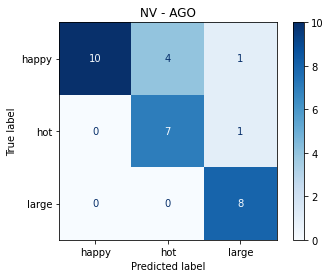

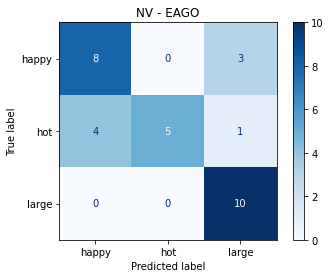

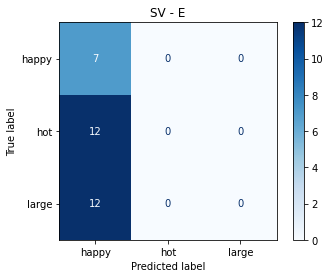

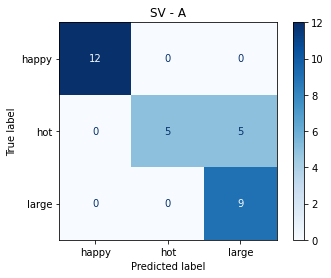

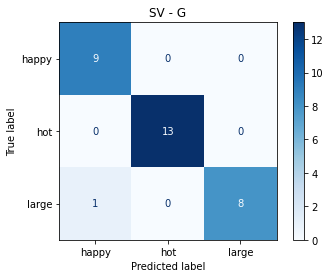

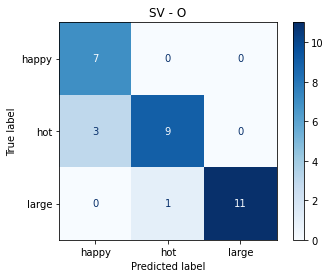

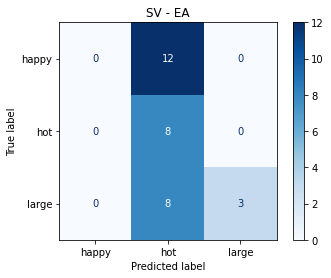

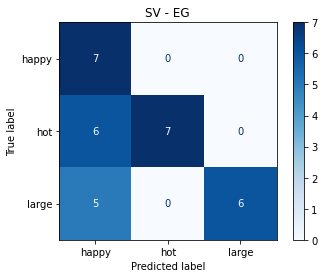

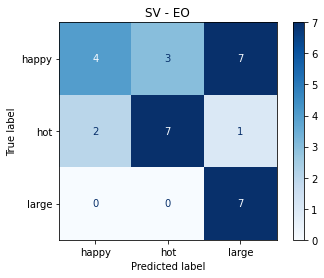

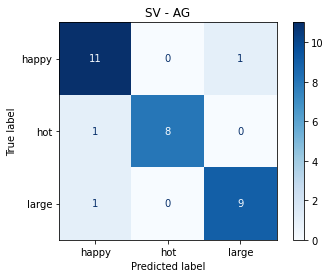

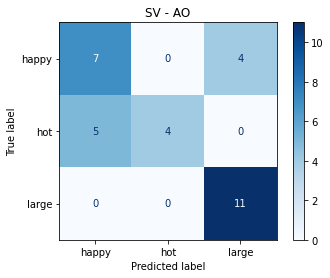

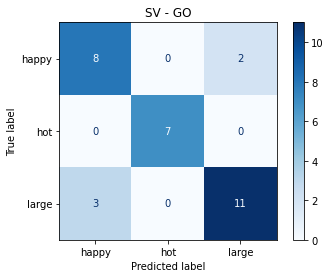

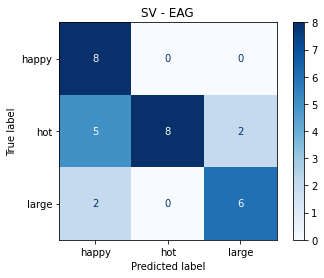

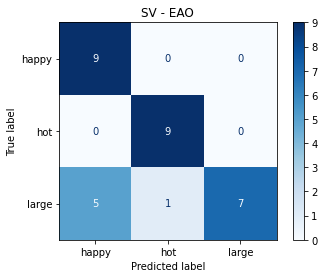

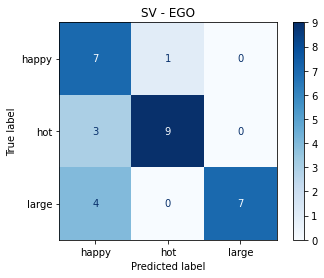

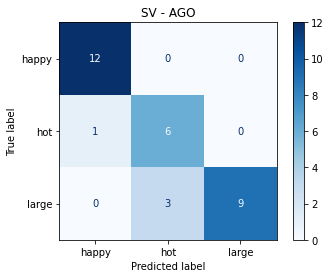

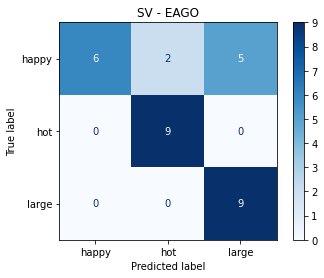

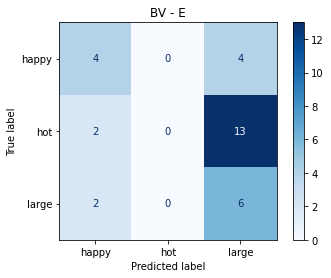

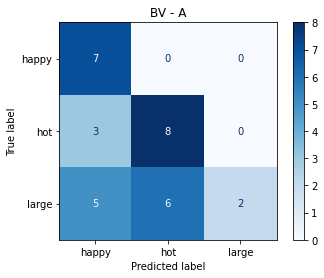

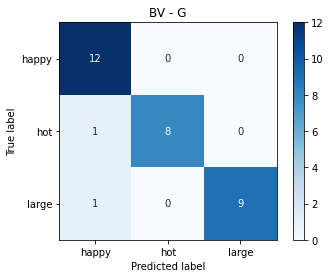

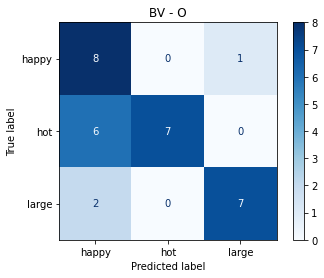

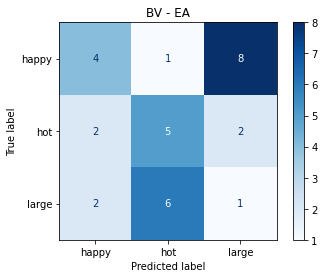

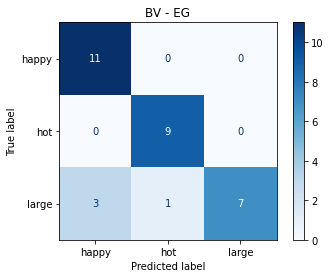

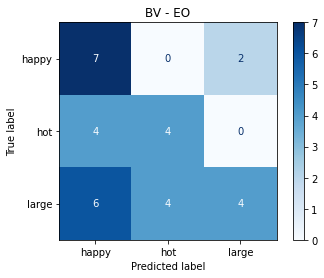

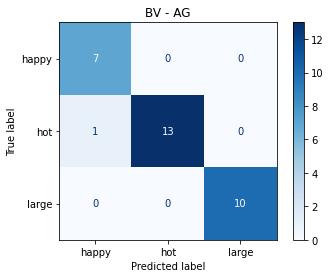

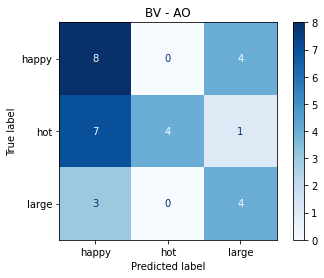

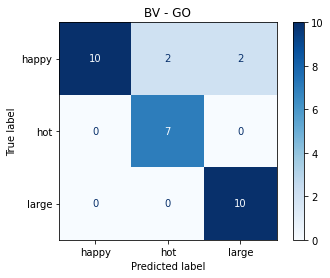

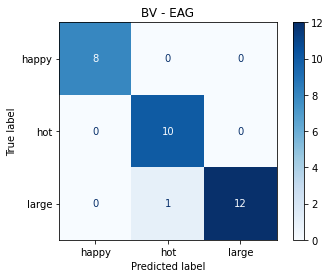

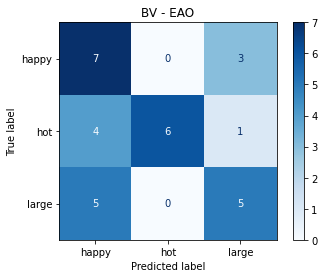

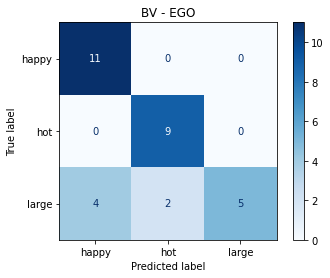

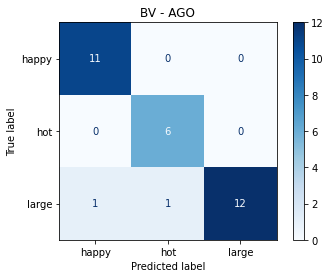

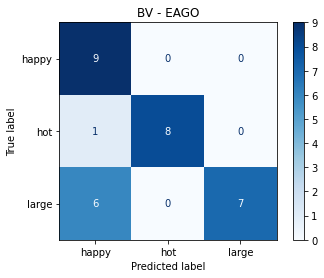

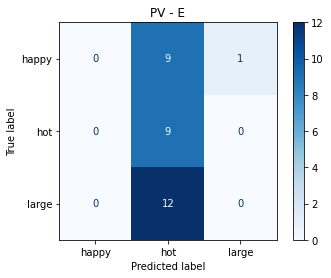

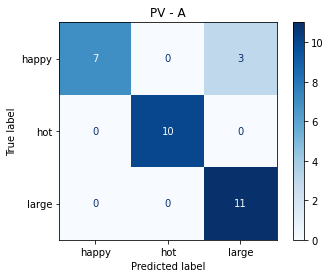

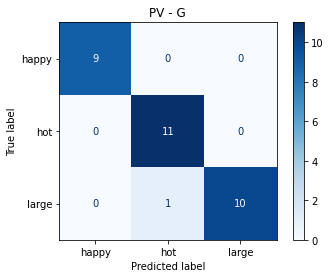

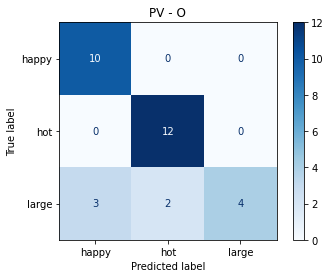

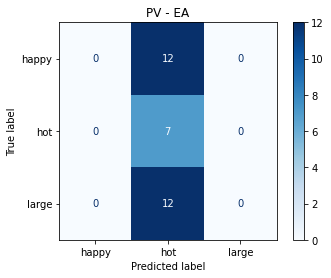

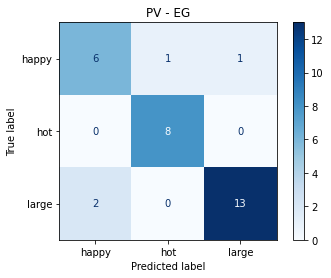

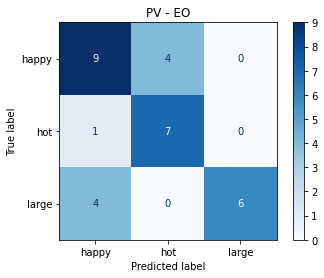

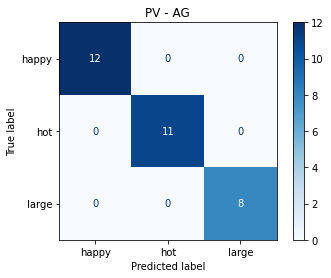

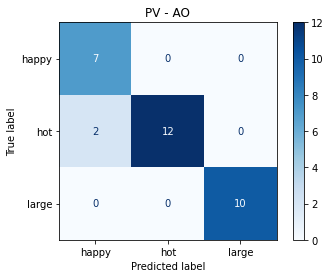

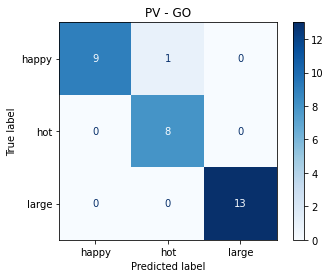

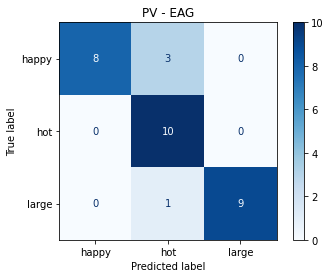

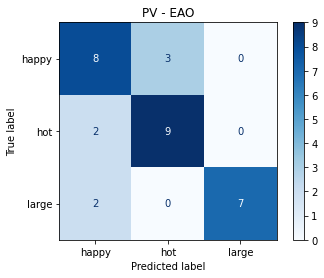

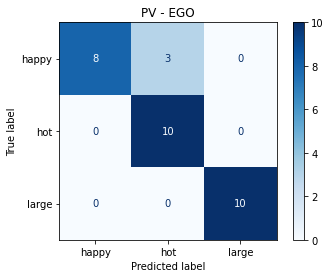

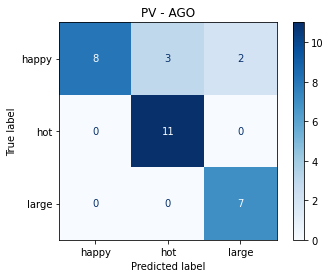

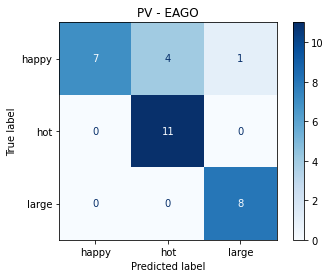

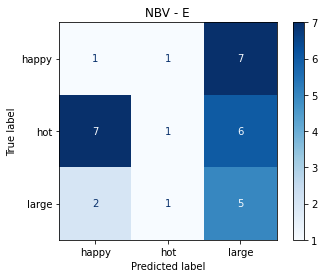

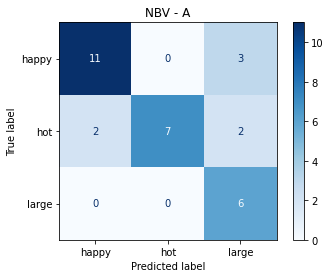

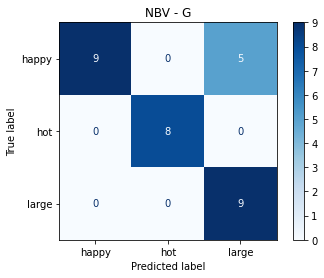

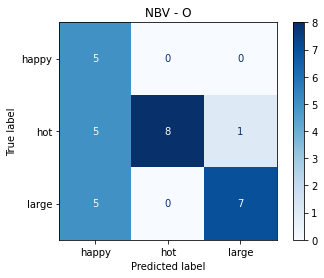

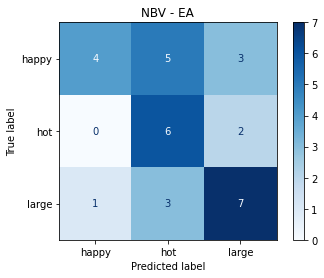

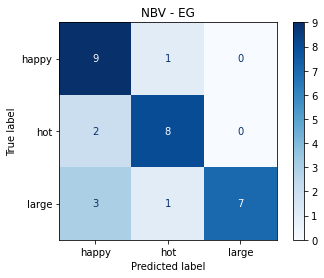

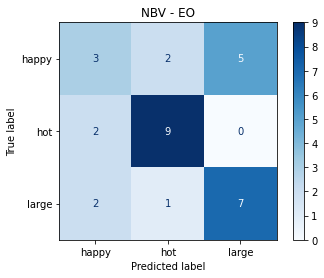

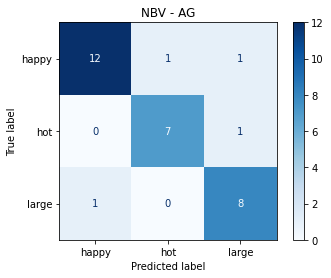

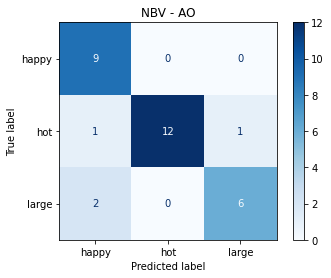

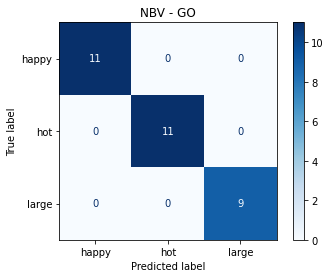

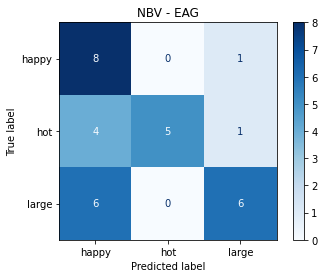

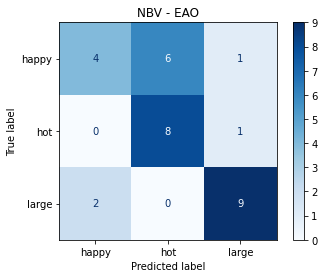

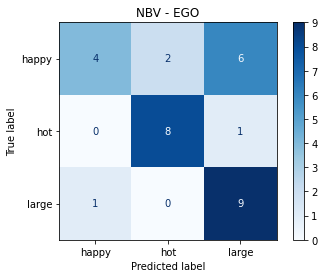

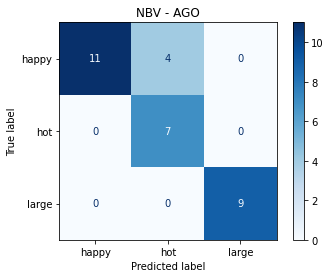

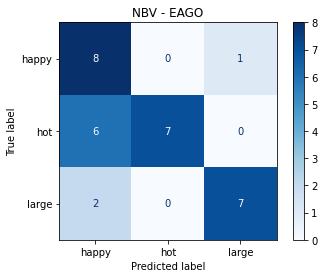

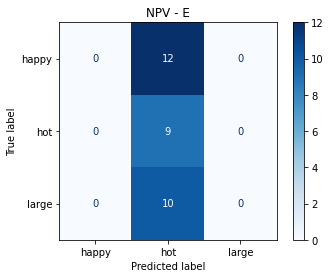

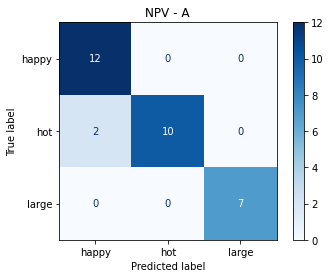

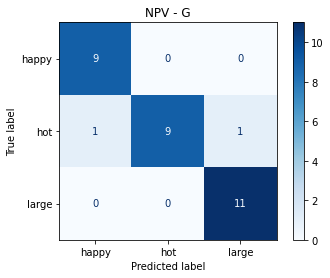

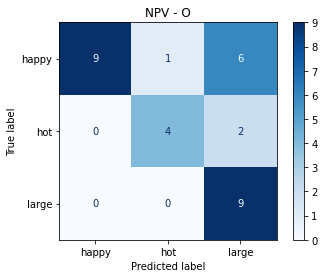

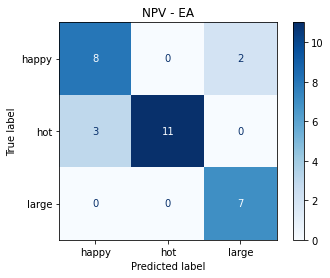

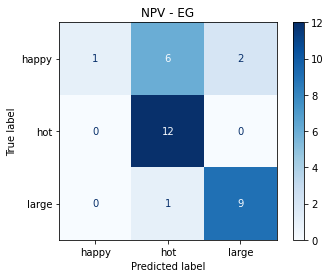

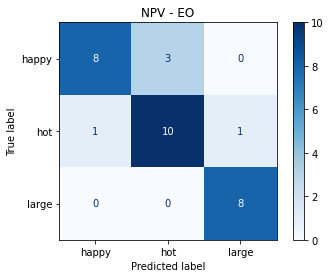

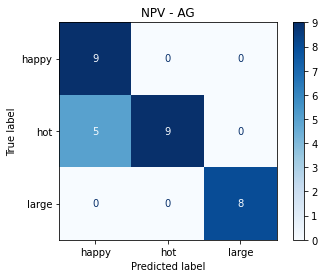

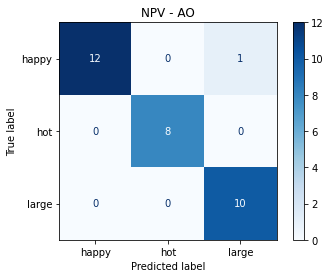

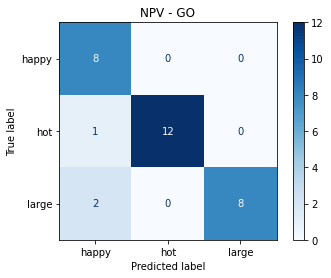

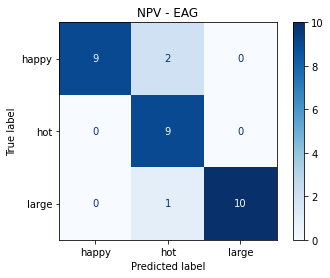

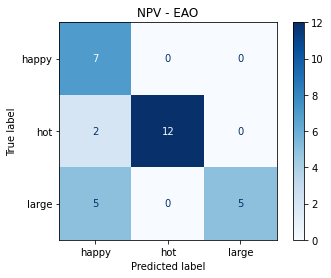

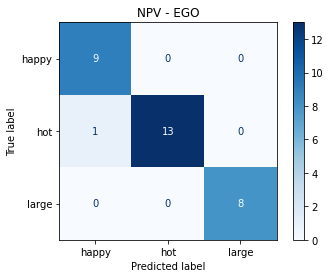

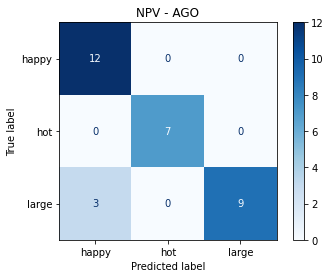

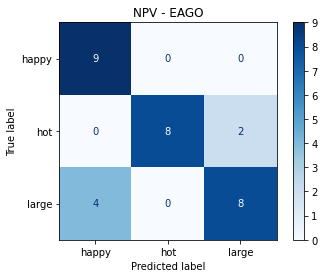

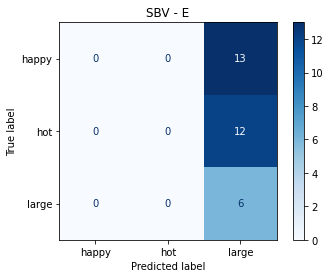

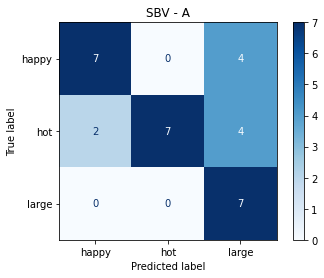

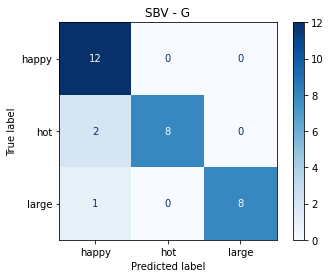

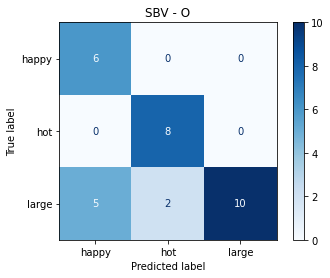

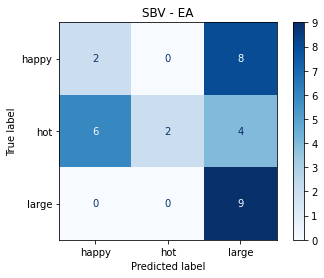

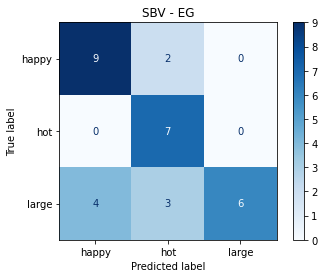

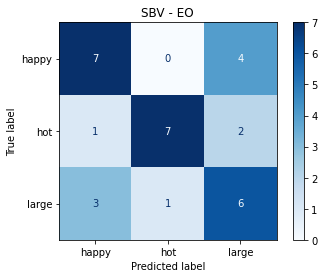

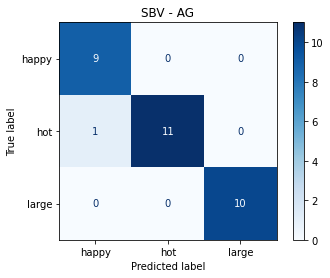

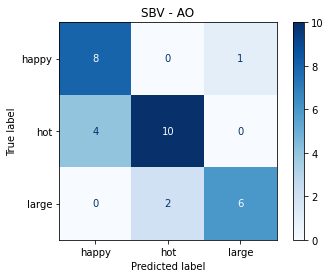

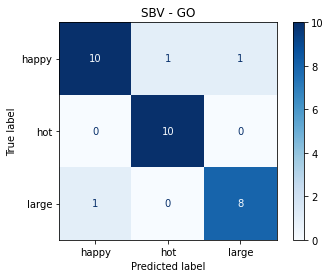

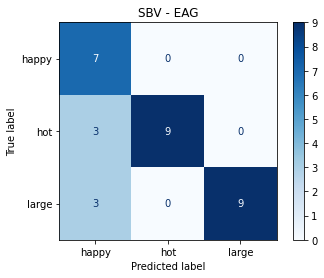

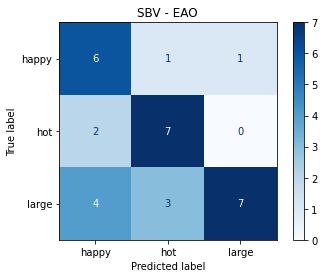

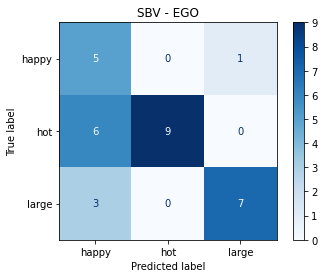

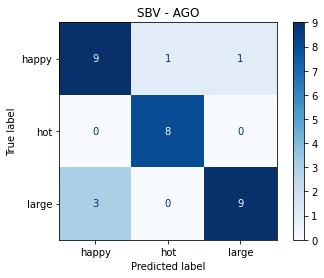

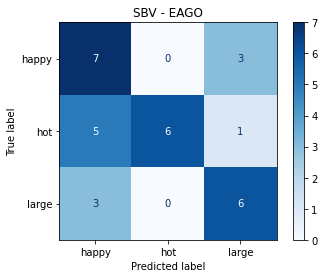

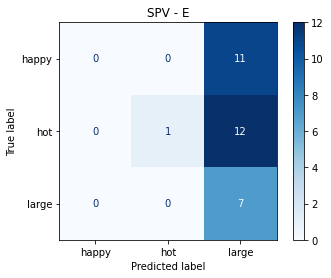

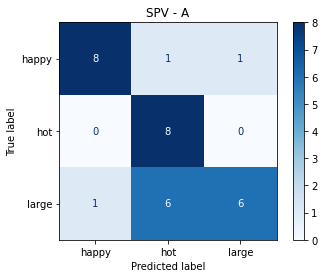

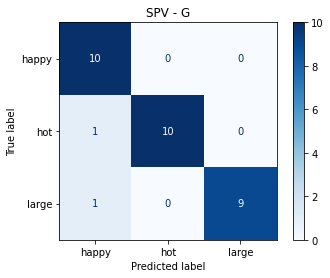

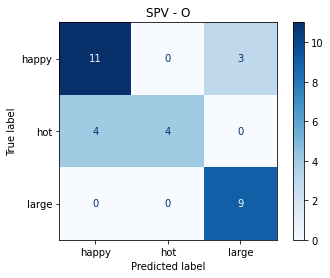

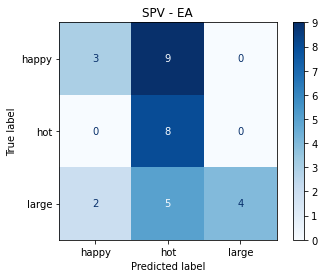

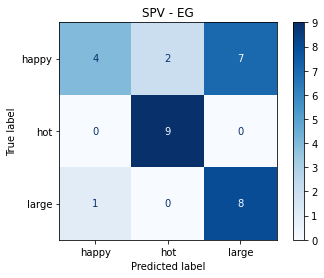

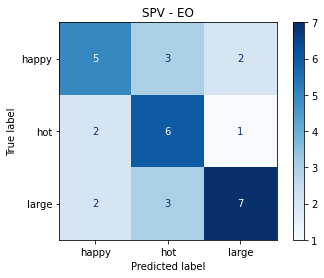

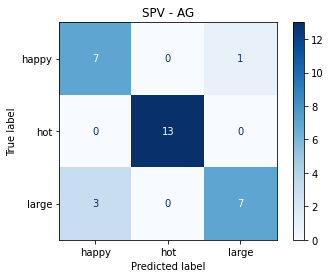

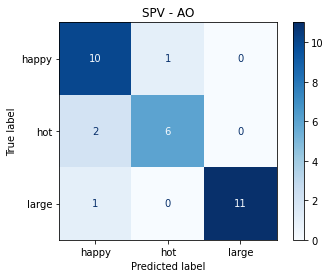

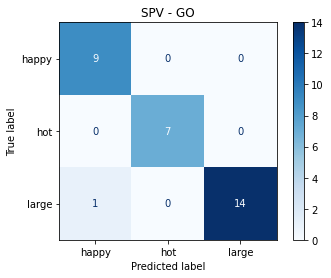

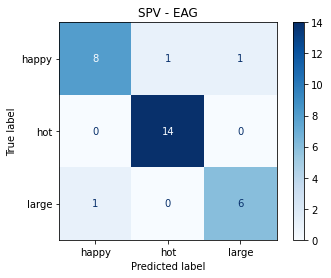

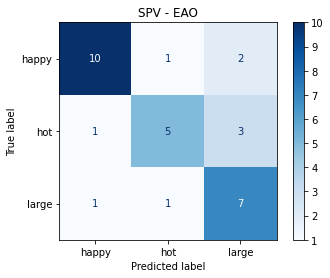

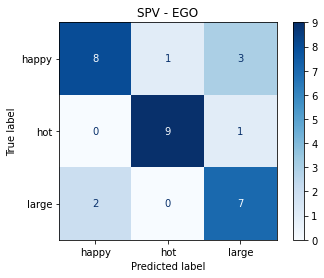

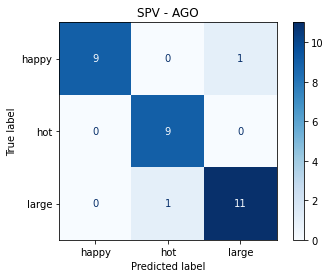

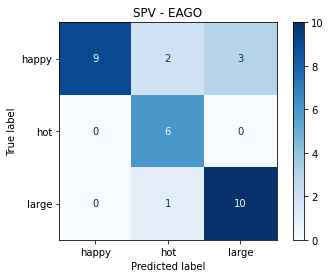

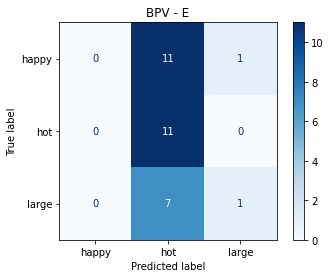

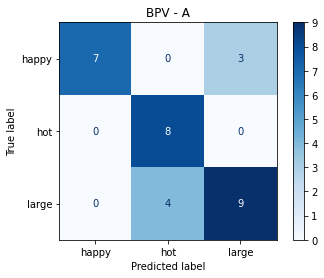

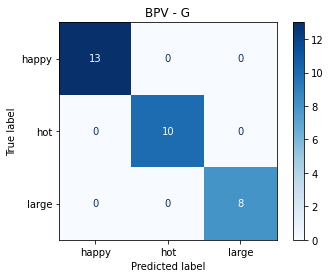

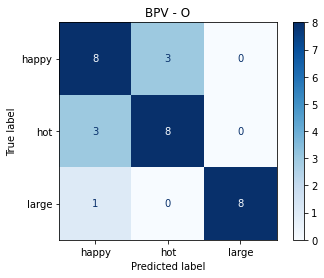

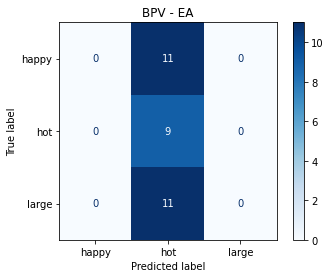

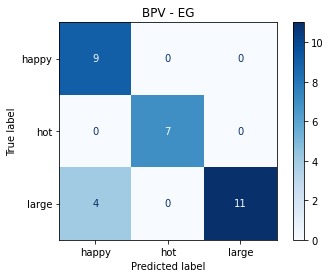

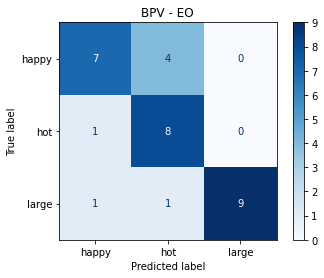

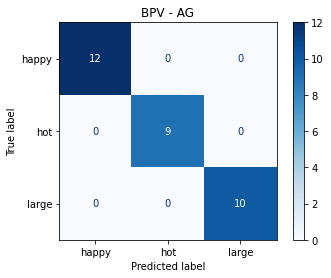

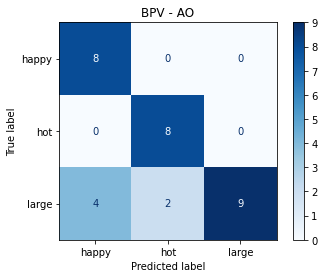

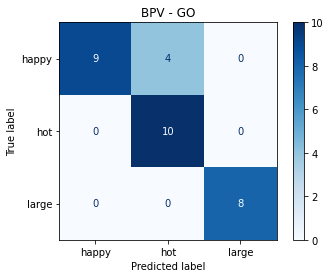

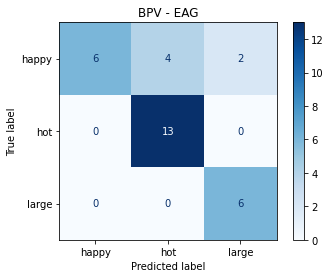

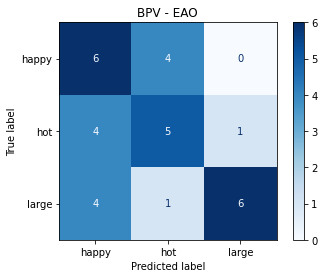

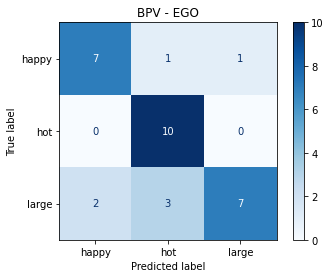

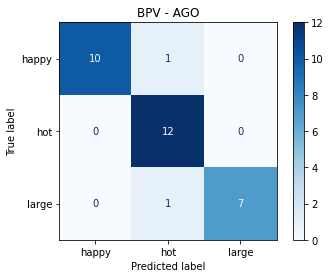

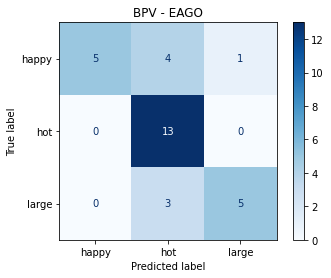

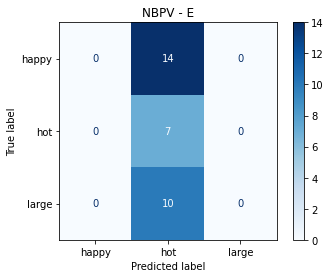

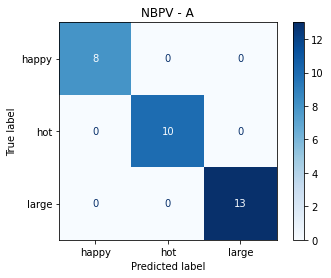

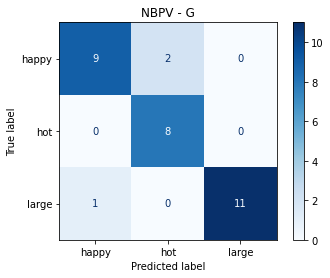

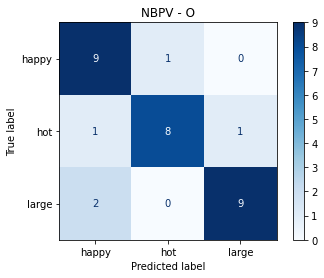

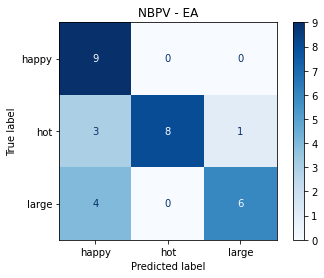

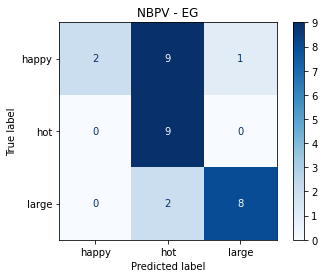

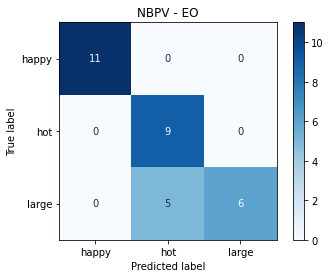

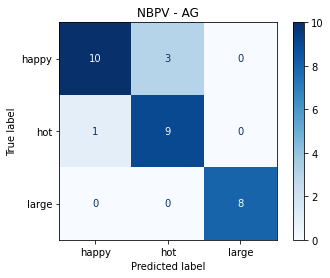

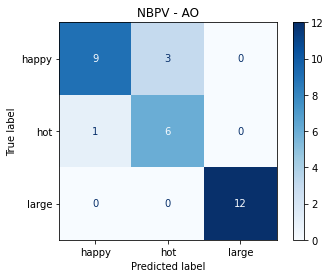

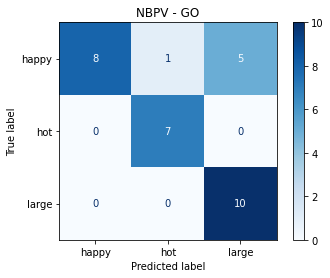

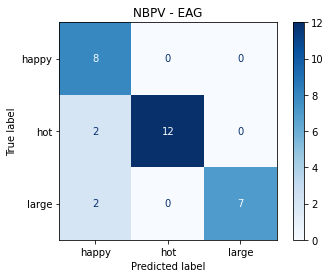

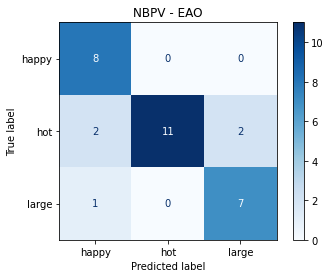

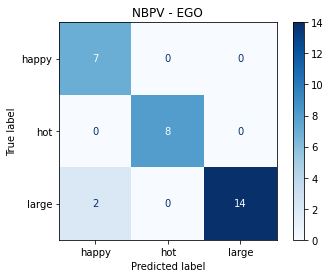

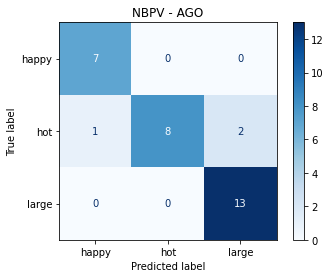

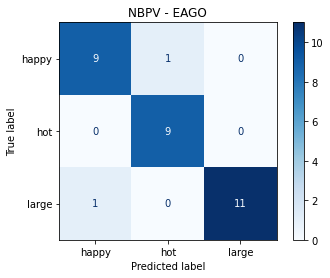

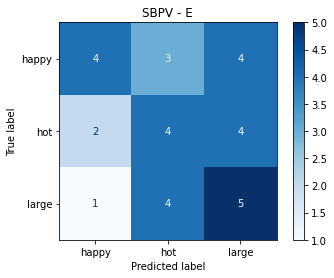

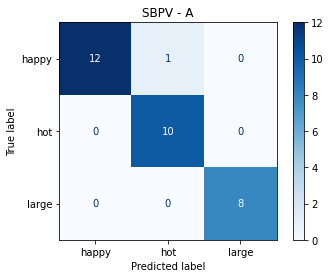

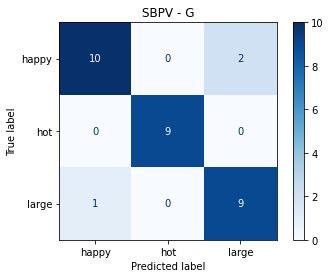

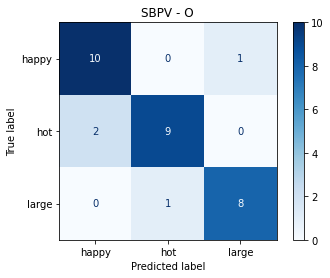

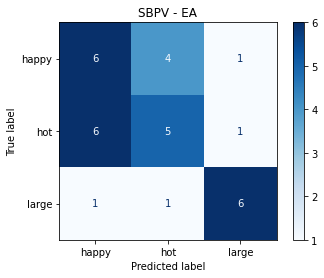

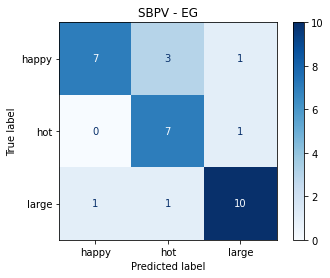

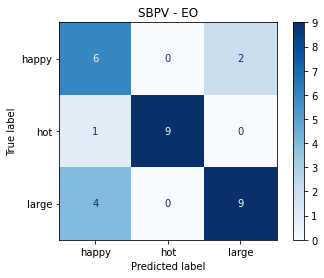

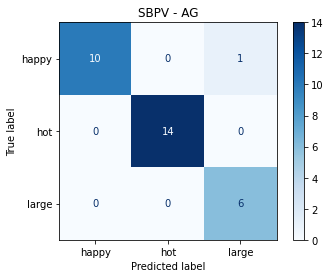

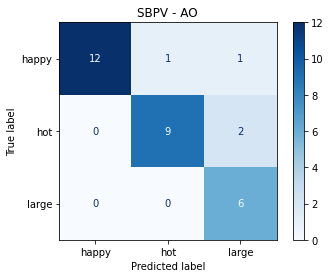

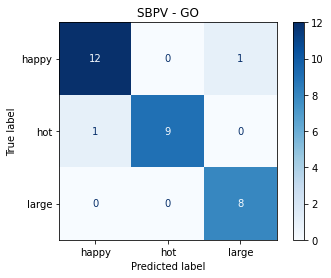

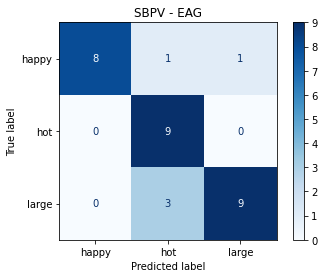

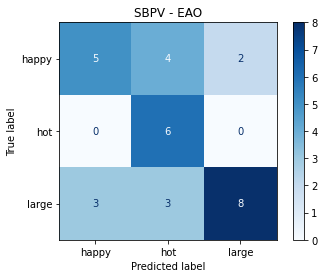

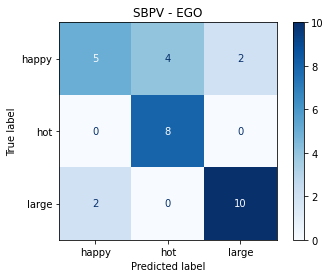

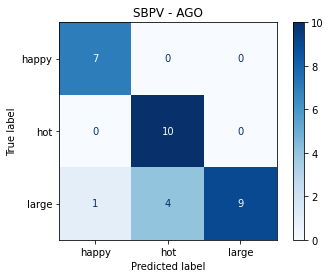

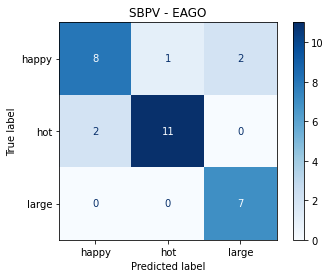

In [12]:
for st in steps:
  rownum+=1
  columnnum=-1
  for pr in regproducts:
    columnnum+=1
    combo=nsteps[rownum]+' - '+comb[columnnum]
    words=set(pr['Word']) # Obtain the target names for the SVM
    
    # First step: set input matrix as regular, normalized or standardized
    input_matrix=pr
    if st%3==0: # Normalization
      input_matrix=normproducts[columnnum]
    if st%5==0: # Standardization
      input_matrix=stanproducts[columnnum]
    
    # Second step: apply Butterworth
    two_matrix=input_matrix
    if st%7==0: # Butterworth
      two_matrix=butterworth(input_matrix)
    
    # Third step: split data for later steps
    x_train, x_test, y_train, y_test=datasplit(two_matrix)
    
    # Fourth step: apply PCA
    x_t_train=x_train
    x_t_test=x_test
    if st%11==0: # PCA
      x_train, x_test, y_train, y_test, x_t_train, x_t_test=pca(x_train, x_test, y_train, y_test)
    
    # Fifth step: apply SVM
    if st%13==0: # SVM
      #svmresults,accuracy,par=svm(x_train, x_test, y_train, y_test, x_t_train, x_t_test,combo)
      svmresults,accuracy=svm(x_train, x_test, y_train, y_test, x_t_train, x_t_test,combo)
    
    #print('The best parameters for',combo,'are:',par)
    fresults[rownum,columnnum]=accuracy*100
fresults=pd.DataFrame(fresults,index=nsteps,columns=comb)
exec("fresults.to_csv(path_or_buf='/content/results_'+str(numreps)+'.csv')")

endtime=time.time()

# **5. Results**

In [13]:
print(fresults)
print('The maximum accuracy for',numreps,'repetitions is',fresults.max().max())
print('The program executed in '+str(endtime-starttime)+' seconds')

              E          A          G  ...        EGO        AGO       EAGO
V     36.916667  69.916667  81.166667  ...  73.333333  48.166667  55.250000
NV    11.000000  59.416667  81.166667  ...  44.750000  67.000000  62.833333
SV    22.000000  62.583333  81.666667  ...  22.000000  63.333333  37.166667
BV    48.166667  63.083333  81.666667  ...  33.250000  51.833333  51.583333
PV    22.250000  70.166667  88.500000  ...  59.666667  70.416667  77.750000
NBV   47.916667  59.416667  78.000000  ...  36.916667  85.333333  55.250000
NPV   25.916667  77.750000  63.083333  ...  63.083333  67.000000  59.666667
SBV   30.083333  22.500000  77.750000  ...  55.750000  59.666667  36.666667
SPV   33.500000  88.250000  67.000000  ...  73.583333  74.333333  67.000000
BPV   33.250000  63.083333  78.000000  ...  63.083333  63.083333  59.166667
NBPV  40.833333  52.333333  70.416667  ...  59.416667  88.500000  66.250000
SBPV  22.000000  66.750000  81.666667  ...  63.083333  74.333333  51.583333

[12 rows x 